<a href="https://colab.research.google.com/github/bacchus00/deep-learning-submissions/blob/main/Tarea_2_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2
### Integrantes: Sebastián Contreras, Fran Zautzik

En esta tarea vas a experimentar con diferentes funciones de activación y su rol en el aprendizaje de redes neuronales. Lo primero que haremos es importar los paquetes importantes para nuestro notebook e inicializar el gpu. Asegúrate que tu notebook se ejecuta sobre un GPU. Si es así, al ejecutar la siguiente celda debería salirte el mensaje "cuda".

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


A continuación hay un conjunto de funciones que puedes usar para hacer tus experimentos. Los detalles de cada función están como comentario antes del código de la función.

In [ ]:
#Esta función permite inicializar todas las semillas de números pseudoaleatorios.
# Puedes usar esta función para resetear los generadores de números aleatorios
def iniciar_semillas():
  SEED = 1234

  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

#Función para computar el accuracy. Se asume que predicciones y etiquetas son tensores en el GPU
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

#Función para entrenar una época de un modelo. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -optimizer: el optimizador para el entrenamiento
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def train_one_epoch(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation
  model.train()

  #Training loop
  for (x, y) in iterator:
    x = x.to(device) #Data
    y = y.long().to(device) #Labels

    optimizer.zero_grad() #Clean gradients

    y_pred = model(x) #Feed the network with data

    loss = criterion(y_pred, y) #Compute the loss

    acc = calculate_accuracy(y_pred, y) #Compute the accuracy

    loss.backward() #Compute gradients

    optimizer.step() #Apply update rules

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Función que evalúa una red neuronal con un conjunto de datos de prueba. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for
  #training (dropout for instance)
  model.eval()

  with torch.no_grad(): #disable the autograd engine (save computation and memory)

    for (x, y) in iterator:
      x = x.to(device)
      y = y.long().to(device)

      y_pred= model(x)

      loss = criterion(y_pred, y)

      acc = calculate_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Calcula el tiempo transcurrido entre dos timestamps
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#Esta función realiza el entrenamiento completo de una red. Recibe como parámetros:
#     -network: la red neuronal
#     -optimizer: el optimizador para entrenamiento
#     -train_loader: el dataloader de datos de entrenamiento
#     -tes_loader: el dataloader de datos de prueba
#     -name: nombre a usar para guardar en disco la red con el mejor accuracy

def train_complete(network, optimizer, train_loader, test_loader, name):

  #Se envían la red y la función de loss al GPU
  network = network.to(device)
  criterion = nn.CrossEntropyLoss()
  criterion = criterion.to(device)

  #Fijar el entrenamiento en 20 épocas siempre
  EPOCHS = 20

  best_valid_acc = float('-inf')

  for epoch in range(EPOCHS):

    start_time = time.time()

    #Train + validation cycles
    train_loss, train_acc = train_one_epoch(network, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(network, test_loader, criterion, device)

    #Si encontramos un modelo con accuracy de validación mayor, lo guardamos
    if valid_acc > best_valid_acc:
     best_valid_acc = valid_acc
     torch.save(network.state_dict(), f'{name}.pt')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  #Cuando se termina el entrenamiento, cargamos el mejor modelo guardado y calculamos el accuracy de prueba
  network.load_state_dict(torch.load(f'{name}.pt'))

  test_loss , test_acc = evaluate(network, test_loader, criterion, device)
  print(f'Test Loss: {test_loss:.3f} | Mejor test acc: {test_acc*100:.2f}%')

Para nuestros experimentos usaremos el dataset FashionMNIST, que consta de imágenes en escala de grises de 28x28 píxeles que representan prendas de ropa clasificadas en 10 clases. Inicializamos los hiperparámetros y cargamos los conjuntos de datos de entrenamiento y prueba. También se crean los dataloaders correspondientes.

In [ ]:
# Hyper-parameters
input_size = 784
num_classes = 10
batch_size_train = 1000
batch_size_test = 1000
momentum = 0.9
log_interval = 100
learning_rate=0.01

# MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='data',
                    train=True,
                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]),
                    download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='data',
                                          train=False,
                                          transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]))


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size_train,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size_test,
                                          shuffle=False)

class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Inspeccionamos algunas muestras del conjunto de datos de prueba

Numero de batch: 0
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


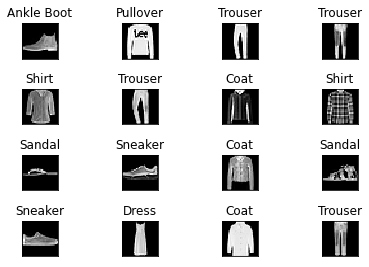

In [ ]:
examples = enumerate(test_loader) #Crea un iterador sobre la lista de batches

batchId, (exampleData, exampleTargets) = next(examples) #Obtenemos el siguiente batch
print('Numero de batch: {}'.format(batchId))
print(exampleData.shape)
print(exampleTargets.shape)

import matplotlib.pyplot as plt

#Mostramos los primeros 6 elementos del batch con su etiqueta
plt.figure()
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.tight_layout()
  plt.imshow(exampleData[i][0], cmap='gray', interpolation='none')
  plt.title(class_names[exampleTargets[i]])
  plt.xticks([])
  plt.yticks([])

# Parte 1 - Creación de red neuronal
Crea una arquitectura de red neuronal (MLP - multilayer perceptron) que reciba datos de 784 dimensiones (recuerda que las imágenes del experimento son de 28x28 = 784 píxeles) y tenga 10 neuronas de salida. Para esta primera red usa la función sigmoide como función de activación en todas las capas ocultas y la función softmax en la capa de salida (recuerda que si usas nn.CrossEntropyLoss, no necesitas aplicar ninguna función adicional a la última capa de la red).

In [ ]:
#Creamos la red neuronal
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## NOTA:
Para probar cada una de las funciones de activacion se crearon dos arquitecturas, una de 1 capa oculta con 4 neuronas y luego una de 3 capas con una cantidad considerable de neuronas, esto para ver si hay diferencias ocupar las funciones en una arquitectura minimal vs una arquitectura mas profunda.

## Sigmoid

In [ ]:
# 1 capa oculta
class NetSigmoid(nn.Module):
  def __init__(self):
    super(NetSigmoid, self).__init__()
    # Define aquí las capas de tu red
    self.fc1 = nn.Linear(784, 4)
    self.fc2 = nn.Linear(4,10)

  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    h_1 = F.sigmoid(self.fc1(input))
    y_pred = self.fc2(h_1)

    return y_pred

Para ejecutar el entrenamiento de tu primer modelo, ejecuta la siguiente celda y debería reportarte el accuracy de prueba de este primer experimento. Cuánto obtienes de accuracy de test?

In [ ]:
iniciar_semillas() # Se inicializan las semillas
network = NetSigmoid() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'sigmoid') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 1.917 | Train Acc: 33.95%
	 Val. Loss: 1.631 |  Val. Acc: 50.02%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 1.458 | Train Acc: 55.70%
	 Val. Loss: 1.325 |  Val. Acc: 57.97%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 1.174 | Train Acc: 63.98%
	 Val. Loss: 1.059 |  Val. Acc: 66.52%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.967 | Train Acc: 67.78%
	 Val. Loss: 0.916 |  Val. Acc: 67.17%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.862 | Train Acc: 69.27%
	 Val. Loss: 0.845 |  Val. Acc: 68.29%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.803 | Train Acc: 71.98%
	 Val. Loss: 0.793 |  Val. Acc: 75.24%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.736 | Train Acc: 76.04%
	 Val. Loss: 0.729 |  Val. Acc: 75.21%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.684 | Train Acc: 76.84%
	 Val. Loss: 0.687 |  Val. Acc: 76.46%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.652 | Train Acc: 77.24%
	 Val. Loss: 0.680 |  Val. Acc: 76.09%
Epoch: 10 | Epoch T

In [ ]:
# 3 capas ocultas
class NetSigmoid(nn.Module):
  def __init__(self):
    super(NetSigmoid, self).__init__()
    # Define aquí las capas de tu red
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,10)

  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    h_1 = F.sigmoid(self.fc1(input))
    h_2 = F.sigmoid(self.fc2(h_1))
    h_3 = F.sigmoid(self.fc3(h_2))
    y_pred = self.fc4(h_3)
    return y_pred

iniciar_semillas() # Se inicializan las semillas
network = NetSigmoid() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'sigmoid') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 1.278 | Train Acc: 49.84%
	 Val. Loss: 0.744 |  Val. Acc: 71.78%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.577 | Train Acc: 78.49%
	 Val. Loss: 0.503 |  Val. Acc: 82.74%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.428 | Train Acc: 84.83%
	 Val. Loss: 0.452 |  Val. Acc: 83.98%
Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.385 | Train Acc: 86.31%
	 Val. Loss: 0.431 |  Val. Acc: 83.82%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.359 | Train Acc: 87.21%
	 Val. Loss: 0.417 |  Val. Acc: 85.08%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.339 | Train Acc: 87.87%
	 Val. Loss: 0.394 |  Val. Acc: 86.01%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.326 | Train Acc: 88.25%
	 Val. Loss: 0.375 |  Val. Acc: 86.55%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.321 | Train Acc: 88.46%
	 Val. Loss: 0.391 |  Val. Acc: 86.15%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.310 | Train Acc: 88.68%
	 Val. Loss: 0.376 |  Val. Acc: 86.74%
Epoch: 10 | Epoch T

# Parte 2
En esta parte vas a comparar el accuracy de test de la primera red que creaste (con función de activación sigmoide) y los accuracys obtenidos usando otras funciones de activación. Para lograr esto debes hacer lo siguiente:



*   Implementa exactamente la misma arquitectura que tu primera red, pero ahora vas a usar las siguientes funciones de activación: Leaky Relu, Mish, Elu y Silu. Implementa una clase por cada función de activación, en donde la red neuronal use la misma función de activación en las capas ocultas. Asegúrate que la arquitectura es la misma y que lo único que cambia entre las distintas redes es la función de activación de las capas ocultas.
*   Entrena cada red usando la función "train_complete" usando el mismo optimizador siempre.
*   Registra los mejores accuracys de test de cada red neuronal.
*   Discute los resultados ontenidos. Puedes tratar de responder a estas preguntas:
    * Qué función de activación dio el mejor accuracy de test?
    * Porqué crees que, ante las mismas condiciones, hay funciones de activación que funcionan mejor que otras?
    * Averigua cómo funcionan cada una de las funciones de activación usadas en la tarea. Es posible hacer algún razonamiento sobre el comportamiento de cada función y que eso permita explicar los resultados de tu tarea?

#Leaky Relu

In [ ]:
# 1 capa oculta
class NetLeakyRelu(nn.Module):
  def __init__(self):
    super(NetLeakyRelu, self).__init__()
    # Define aquí las capas de tu red
    self.fc1 = nn.Linear(784, 4)
    self.fc2 = nn.Linear(4,10)

  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    h_1 = F.leaky_relu(self.fc1(input))
    y_pred = self.fc2(h_1)

    return y_pred

iniciar_semillas() # Se inicializan las semillas
network = NetLeakyRelu() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'leaky_relu') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 1.768 | Train Acc: 34.77%
	 Val. Loss: 1.299 |  Val. Acc: 50.54%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 1.092 | Train Acc: 61.81%
	 Val. Loss: 0.949 |  Val. Acc: 66.56%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.852 | Train Acc: 69.44%
	 Val. Loss: 0.819 |  Val. Acc: 69.99%
Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.767 | Train Acc: 72.90%
	 Val. Loss: 0.763 |  Val. Acc: 73.44%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.720 | Train Acc: 73.99%
	 Val. Loss: 0.729 |  Val. Acc: 72.98%
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.681 | Train Acc: 75.45%
	 Val. Loss: 0.683 |  Val. Acc: 75.26%
Epoch: 07 | Epoch Time: 0m 12s
	Train Loss: 0.648 | Train Acc: 77.27%
	 Val. Loss: 0.658 |  Val. Acc: 77.50%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.624 | Train Acc: 78.34%
	 Val. Loss: 0.640 |  Val. Acc: 77.44%
Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 0.607 | Train Acc: 78.97%
	 Val. Loss: 0.633 |  Val. Acc: 77.68%
Epoch: 10 | Epoch T

In [ ]:
# 3 capas ocultas
class NetLeakyRelu(nn.Module):
  def __init__(self):
    super(NetLeakyRelu, self).__init__()
    # Define aquí las capas de tu red
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,10)

  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    h_1 = F.leaky_relu(self.fc1(input))
    h_2 = F.leaky_relu(self.fc2(h_1))
    h_3 = F.leaky_relu(self.fc3(h_2))
    y_pred = self.fc4(h_3)
    return y_pred

iniciar_semillas() # Se inicializan las semillas
network = NetLeakyRelu() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'leaky_relu') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.764 | Train Acc: 71.34%
	 Val. Loss: 0.489 |  Val. Acc: 82.07%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.406 | Train Acc: 85.11%
	 Val. Loss: 0.426 |  Val. Acc: 84.72%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.365 | Train Acc: 86.46%
	 Val. Loss: 0.433 |  Val. Acc: 84.82%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.328 | Train Acc: 87.88%
	 Val. Loss: 0.386 |  Val. Acc: 86.31%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.303 | Train Acc: 88.67%
	 Val. Loss: 0.389 |  Val. Acc: 86.02%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.290 | Train Acc: 89.11%
	 Val. Loss: 0.358 |  Val. Acc: 87.21%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.284 | Train Acc: 89.32%
	 Val. Loss: 0.381 |  Val. Acc: 86.65%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.273 | Train Acc: 89.74%
	 Val. Loss: 0.351 |  Val. Acc: 87.50%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.264 | Train Acc: 90.12%
	 Val. Loss: 0.351 |  Val. Acc: 87.86%
Epoch: 10 | Epoch T

#Mish



In [ ]:
# 1 capa oculta
class NetMish(nn.Module):
  def __init__(self):
    super(NetMish, self).__init__()
    # Define aquí las capas de tu red
    self.fc1 = nn.Linear(784, 4)
    self.fc2 = nn.Linear(4,10)

  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    h_1 = F.mish(self.fc1(input))
    y_pred = self.fc2(h_1)

    return y_pred

iniciar_semillas() # Se inicializan las semillas
network = NetMish() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'mish') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 1.607 | Train Acc: 39.25%
	 Val. Loss: 1.147 |  Val. Acc: 60.02%
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 0.971 | Train Acc: 70.25%
	 Val. Loss: 0.878 |  Val. Acc: 72.38%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.798 | Train Acc: 74.66%
	 Val. Loss: 0.780 |  Val. Acc: 75.06%
Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.710 | Train Acc: 77.25%
	 Val. Loss: 0.718 |  Val. Acc: 76.15%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.677 | Train Acc: 77.65%
	 Val. Loss: 0.689 |  Val. Acc: 76.66%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.648 | Train Acc: 78.42%
	 Val. Loss: 0.666 |  Val. Acc: 77.63%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.632 | Train Acc: 78.66%
	 Val. Loss: 0.666 |  Val. Acc: 77.39%
Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 0.623 | Train Acc: 78.85%
	 Val. Loss: 0.645 |  Val. Acc: 77.80%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.606 | Train Acc: 79.43%
	 Val. Loss: 0.638 |  Val. Acc: 77.99%
Epoch: 10 | Epoch T

In [ ]:
# 3 capas ocultas
class NetMish(nn.Module):
  def __init__(self):
    super(NetMish, self).__init__()
    # Define aquí las capas de tu red
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,10)

  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    h_1 = F.mish(self.fc1(input))
    h_2 = F.mish(self.fc2(h_1))
    h_3 = F.mish(self.fc3(h_2))
    y_pred = self.fc4(h_3)
    return y_pred

iniciar_semillas() # Se inicializan las semillas
network = NetMish() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'mish') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.779 | Train Acc: 71.03%
	 Val. Loss: 0.504 |  Val. Acc: 81.33%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.414 | Train Acc: 84.74%
	 Val. Loss: 0.409 |  Val. Acc: 85.03%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.357 | Train Acc: 86.75%
	 Val. Loss: 0.397 |  Val. Acc: 85.32%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.325 | Train Acc: 87.93%
	 Val. Loss: 0.384 |  Val. Acc: 85.60%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.303 | Train Acc: 88.78%
	 Val. Loss: 0.363 |  Val. Acc: 86.85%
Epoch: 06 | Epoch Time: 0m 9s
	Train Loss: 0.293 | Train Acc: 89.09%
	 Val. Loss: 0.354 |  Val. Acc: 87.37%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.274 | Train Acc: 89.71%
	 Val. Loss: 0.366 |  Val. Acc: 87.42%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.271 | Train Acc: 89.87%
	 Val. Loss: 0.344 |  Val. Acc: 88.05%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.256 | Train Acc: 90.46%
	 Val. Loss: 0.341 |  Val. Acc: 88.07%
Epoch: 10 | Epoch Ti

#Elu

In [ ]:
# 1 capa oculta
class NetElu(nn.Module):
  def __init__(self):
    super(NetElu, self).__init__()
    # Define aquí las capas de tu red
    self.fc1 = nn.Linear(784, 4)
    self.fc2 = nn.Linear(4,10)

  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    h_1 = F.elu(self.fc1(input))
    y_pred = self.fc2(h_1)

    return y_pred

iniciar_semillas() # Se inicializan las semillas
network = NetElu() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'elu') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 1.419 | Train Acc: 50.98%
	 Val. Loss: 0.984 |  Val. Acc: 66.97%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.833 | Train Acc: 71.49%
	 Val. Loss: 0.767 |  Val. Acc: 73.37%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.722 | Train Acc: 74.65%
	 Val. Loss: 0.721 |  Val. Acc: 74.36%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.690 | Train Acc: 75.46%
	 Val. Loss: 0.696 |  Val. Acc: 75.89%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.654 | Train Acc: 77.59%
	 Val. Loss: 0.676 |  Val. Acc: 77.08%
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.631 | Train Acc: 78.47%
	 Val. Loss: 0.661 |  Val. Acc: 77.54%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.618 | Train Acc: 78.98%
	 Val. Loss: 0.641 |  Val. Acc: 78.36%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.608 | Train Acc: 79.37%
	 Val. Loss: 0.638 |  Val. Acc: 78.45%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.603 | Train Acc: 79.36%
	 Val. Loss: 0.641 |  Val. Acc: 78.20%
Epoch: 10 | Epoch T

In [ ]:
# 3 capas ocultas
class NetElu(nn.Module):
  def __init__(self):
    super(NetElu, self).__init__()
    # Define aquí las capas de tu red
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,10)

  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    h_1 = F.elu(self.fc1(input))
    h_2 = F.elu(self.fc2(h_1))
    h_3 = F.elu(self.fc3(h_2))
    y_pred = self.fc4(h_3)

    return y_pred

iniciar_semillas() # Se inicializan las semillas
network = NetElu() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'elu') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.816 | Train Acc: 70.66%
	 Val. Loss: 0.528 |  Val. Acc: 80.41%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.427 | Train Acc: 84.27%
	 Val. Loss: 0.431 |  Val. Acc: 84.22%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.365 | Train Acc: 86.44%
	 Val. Loss: 0.377 |  Val. Acc: 86.26%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.333 | Train Acc: 87.63%
	 Val. Loss: 0.388 |  Val. Acc: 85.77%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.309 | Train Acc: 88.46%
	 Val. Loss: 0.362 |  Val. Acc: 86.97%
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.295 | Train Acc: 88.97%
	 Val. Loss: 0.365 |  Val. Acc: 87.12%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.278 | Train Acc: 89.59%
	 Val. Loss: 0.356 |  Val. Acc: 87.45%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.264 | Train Acc: 90.06%
	 Val. Loss: 0.353 |  Val. Acc: 87.37%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.260 | Train Acc: 90.18%
	 Val. Loss: 0.342 |  Val. Acc: 87.54%
Epoch: 10 | Epoch T

#Silu

In [ ]:
# 1 capa oculta
class NetSilu(nn.Module):
  def __init__(self):
    super(NetSilu, self).__init__()
    # Define aquí las capas de tu red
    self.fc1 = nn.Linear(784, 4)
    self.fc2 = nn.Linear(4,10)

  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    h_1 = F.silu(self.fc1(input))
    y_pred = self.fc2(h_1)

    return y_pred

iniciar_semillas() # Se inicializan las semillas
network = NetSilu() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'silu') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 1.593 | Train Acc: 40.32%
	 Val. Loss: 1.132 |  Val. Acc: 60.05%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.970 | Train Acc: 70.57%
	 Val. Loss: 0.881 |  Val. Acc: 72.26%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.814 | Train Acc: 73.74%
	 Val. Loss: 0.796 |  Val. Acc: 73.43%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.728 | Train Acc: 75.91%
	 Val. Loss: 0.726 |  Val. Acc: 75.72%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.686 | Train Acc: 77.22%
	 Val. Loss: 0.695 |  Val. Acc: 76.87%
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.657 | Train Acc: 77.95%
	 Val. Loss: 0.674 |  Val. Acc: 77.32%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.639 | Train Acc: 78.29%
	 Val. Loss: 0.670 |  Val. Acc: 77.02%
Epoch: 08 | Epoch Time: 0m 14s
	Train Loss: 0.631 | Train Acc: 78.50%
	 Val. Loss: 0.649 |  Val. Acc: 78.08%
Epoch: 09 | Epoch Time: 0m 12s
	Train Loss: 0.611 | Train Acc: 79.15%
	 Val. Loss: 0.646 |  Val. Acc: 78.24%
Epoch: 10 | Epoch T

In [ ]:
# 1 capas ocultas
class NetSilu(nn.Module):
  def __init__(self):
    super(NetSilu, self).__init__()
    # Define aquí las capas de tu red
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,10)

  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    h_1 = F.silu(self.fc1(input))
    h_2 = F.silu(self.fc2(h_1))
    h_3 = F.silu(self.fc3(h_2))
    y_pred = self.fc4(h_3)

    return y_pred

iniciar_semillas() # Se inicializan las semillas
network = NetSilu() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network, optimizer, train_loader, test_loader, 'silu') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.805 | Train Acc: 70.92%
	 Val. Loss: 0.537 |  Val. Acc: 80.25%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.414 | Train Acc: 84.74%
	 Val. Loss: 0.423 |  Val. Acc: 84.74%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.363 | Train Acc: 86.64%
	 Val. Loss: 0.403 |  Val. Acc: 85.22%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.329 | Train Acc: 87.74%
	 Val. Loss: 0.393 |  Val. Acc: 85.57%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.308 | Train Acc: 88.54%
	 Val. Loss: 0.358 |  Val. Acc: 86.65%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.293 | Train Acc: 89.16%
	 Val. Loss: 0.377 |  Val. Acc: 86.78%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.284 | Train Acc: 89.36%
	 Val. Loss: 0.349 |  Val. Acc: 87.54%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.268 | Train Acc: 90.01%
	 Val. Loss: 0.365 |  Val. Acc: 86.24%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.260 | Train Acc: 90.34%
	 Val. Loss: 0.333 |  Val. Acc: 88.44%
Epoch: 10 | Epoch T

#Análisis

En la presente seccion primero se presentan las funciones de activacion y su caracteristicas para luego pasar a el analisis de los resultados de los experimentos realizados anteriormente. Para las funciones es importante considerar tanto su forma como la forma de su derivada puesto que ambas son relevantes a la hora de entrenar y usar backpropagation.

Para la función Sigmoid podemos ver que es una función completamente derivable y monótona creciente, acotada entre 0 y 1, su derivada está acotada entre 0 y 0.25, y tiende a 0 en los extremos.
El hecho de que la derivada sea tan pequeña nos lleva al problema de la disminución del gradiente a medida que se hace backpropagation por la red neuronal. Además el gradiente se satura en 0.

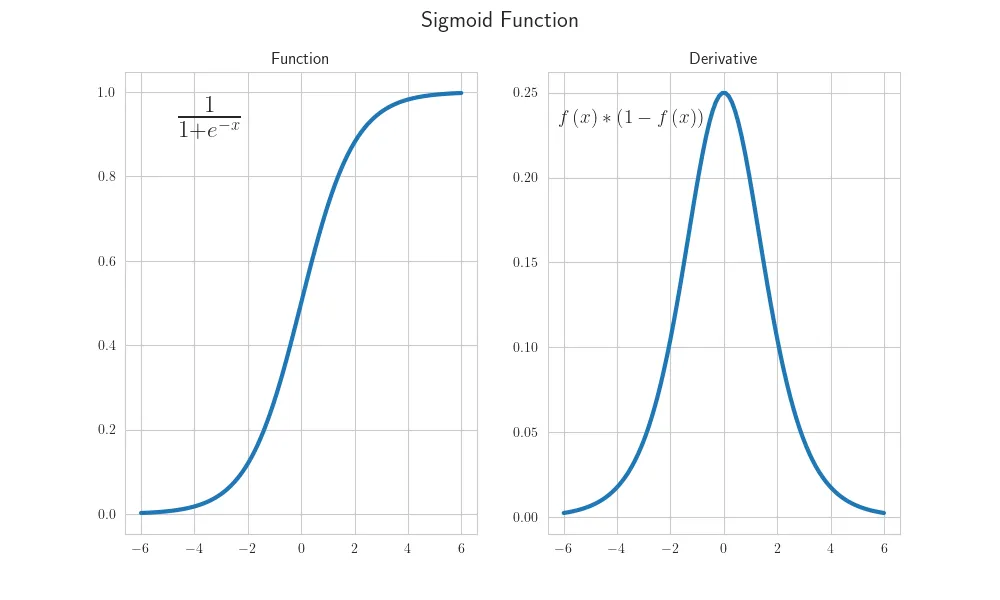

Para Leaky ReLU, podemos ver que se trata de una adaptación de la función ReLU que sí permite valores negativos cuando el input es menor que 0 pero con un output controlado por el hiperparámetro alfa, por lo tanto también se trata de una función monótona creciente. Tiene todas las bondades de la función ReLU, soluciona el problema de gradiente desvaneciente, agrega no-linealidad a la red y soluciona la saturación del gradiente ya que es no acotada por un lado y además soluciona el problema de no actualización de pesos inducido por el descarte de valores negativos dado la naturaleza de la función ReLU. De igual forma que la función ReLU, no es derivable en 0 y además introduce el nuevo hiperparámetro alfa lo que lo vuelve algo que potencialmente puede ser mejor que ReLU.

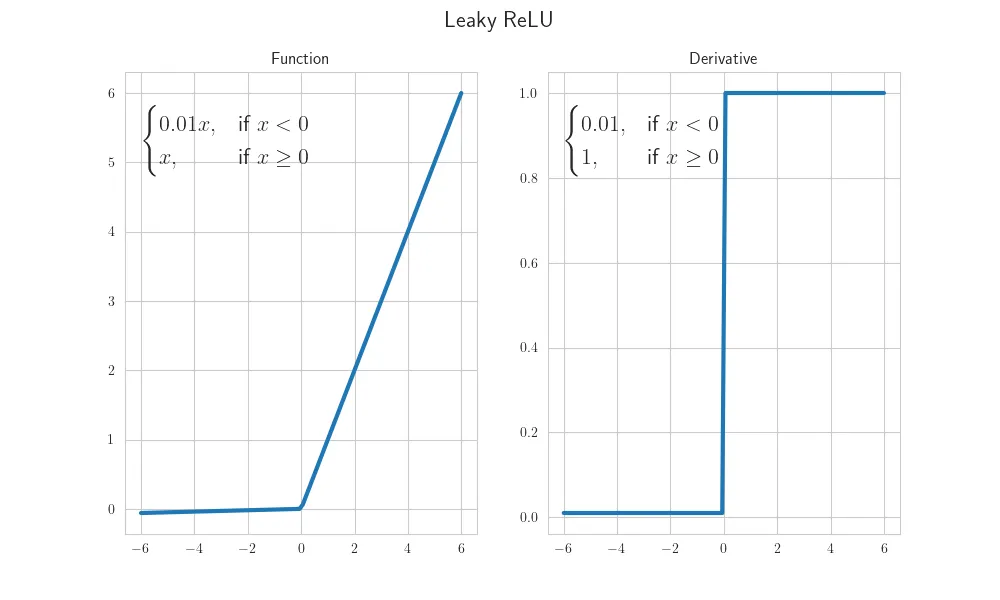



Mish es una función suave, completamente diferenciable, no monótona y acotada por debajo. Como se trata de una función completamente suave, tiene una mayor capacidad de aprendizaje tanto en su velocidad como su capacidad de generalización. Tiene la gracias de que para valores negativos cercanos a 0 las neuronas se activa, pero para valores mas negativos estas no se activan.

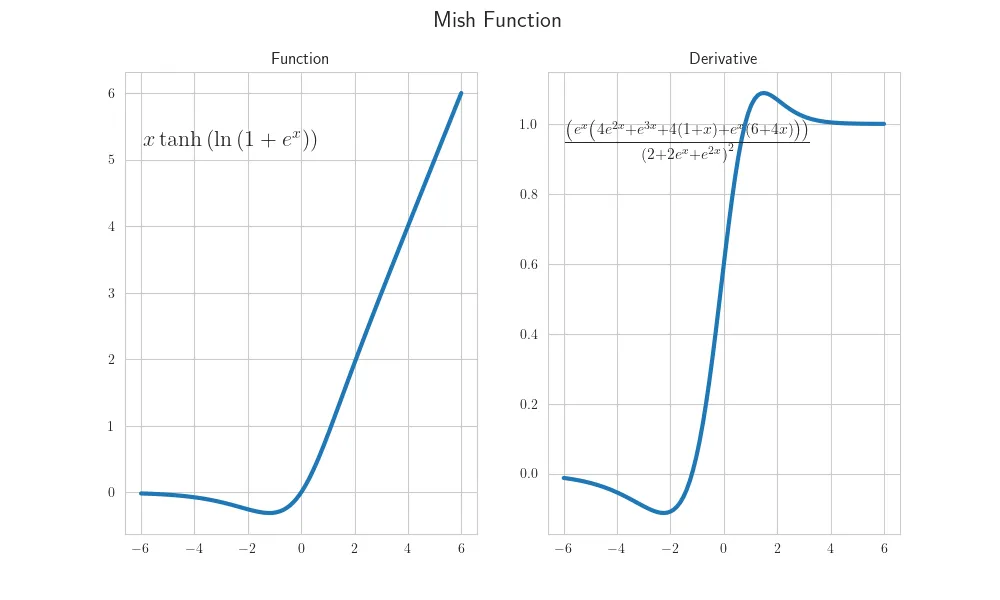

ELU intenta arreglar el mismo problema que Leaky ReLU de no actualización de pesos inducido por el descarte de valores negativos. A diferencia de ReLU y Leaky ReLU, esta función sí es diferenciable en 0 y además es más robusta al ruido. Es claramente monótona creciente, con mayor capacidad de generalización y más rápida capacidad de aprendizaje debido a que es más suave y tiene similitud con batch normalization ya que mueve la media hacia 0 gracias a los valores negativos.

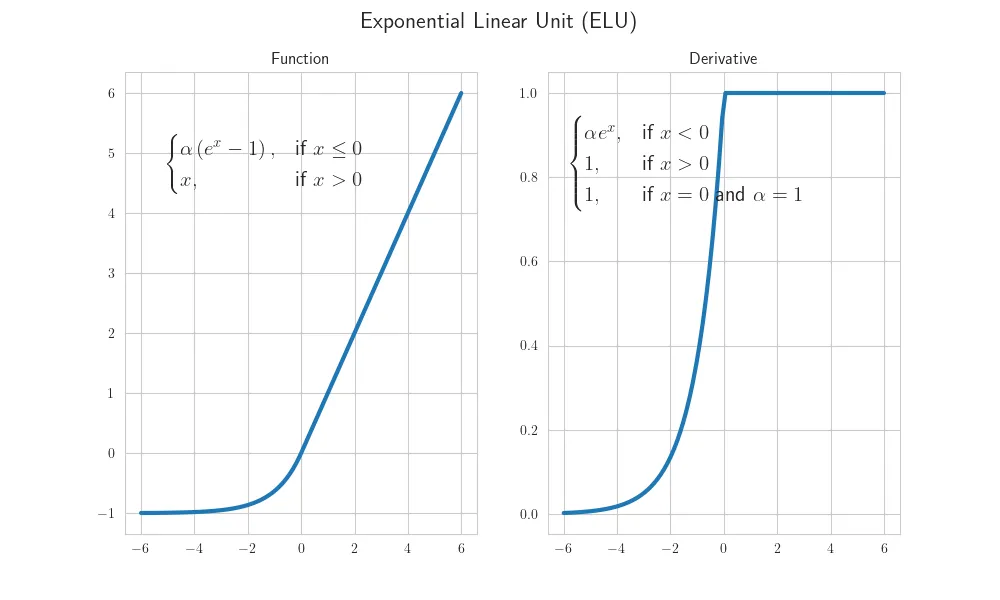

SiLU se puede observar que tiene una forma muy suy similar a la Mish. Como Mish tambien es una funcion suave, completamente diferenciable, no monótona y acotada por debajo. En sentido negativo la derivada tiende a 0 mientras que en sentido positivo la derivada tiende a 1, asique para valores alejados de 0 la funcion es similar a ReLU.

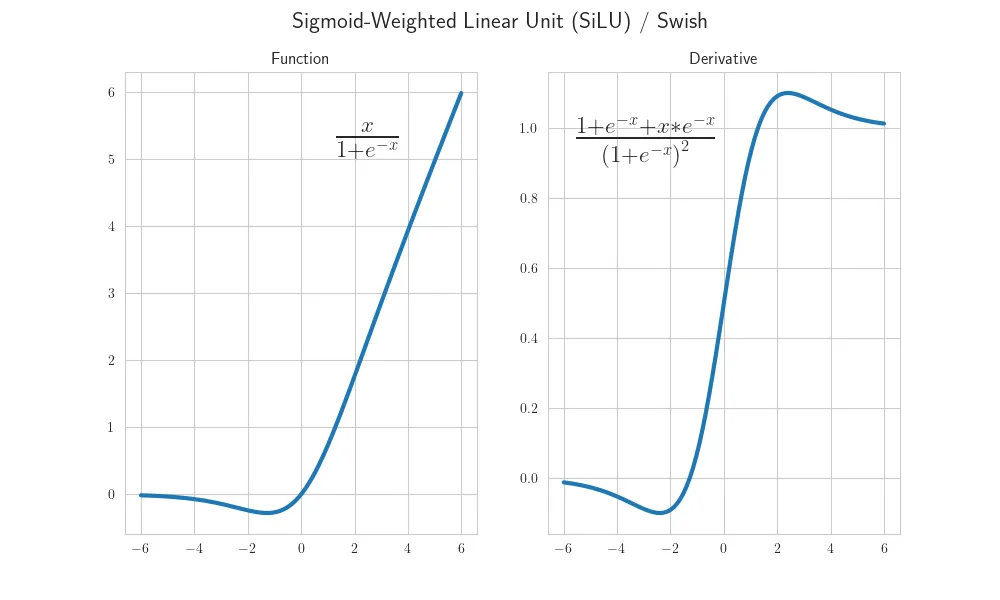


A continucion se muestran los resultados de los mejores accuracies obtenidos en el conjunto de validacion para las diferentes funciones de activación en las capas ocultas. Primero se observan los resultados para una arquitectura de 1 capa oculta con 4 neuronas y luego los resultados para una arquitectura con 3 capas y una cantidad generosa de neuronas.



1 capa y 4 neuronas

|  Función de activación | Mejor accuracy (%) |
|---|---|
| Sigmoid  |  79.73 |
|  Leaky ReLU | 80.09  |
|  Mish | 79.46  |
|  **ELU**  |  **80.52** |
|  SiLU |  79.45 |

3 capas y muchas neuronas

|  Función de activación  | Mejor accuracy (%) |
|---|---|
| Sigmoid  |  87.42 |
|  Leaky ReLU | 88.44  |
|  Mish | 88.50  |
|  **ELU**  |  **88.61** |
|  SiLU |  88.44 |



De los resultados anteriores podemos observar que la función de activación con mejor rendimiento para ambas arquitecturas fue ELU. En cuanto a la segunda mejor función, para el caso de 1 capa esta Leaky ReLU, mientras que para el caso de 3 capas Leaky ReLU, Mish y SiLU tiene desempeños muy cercanos. Viendo los siguientes accuracies para la arquitectura de 1 capa notamos que a continuación viene la función sigmoide y luego, con las peores accuracies, Mish y SiLU. En contraste, en el caso del modelo de 3 capas, Sigmoid es la función de activación con peor desempeño.

De lo anterior vale la pena destacar que, si bien la sigmoide no fue la con peor desempeño para una capa, esta se queda atras al momento de agregar mas capas. En cuanto a la funcion ELU, se cree que su buen desempeño puede deberse a que para todos los valores negativos las neuronas igual se activan pero con un con un valor de como minimo -1, dando asi relevancia limitada a valores negativos grandes. Para Leaky ReLU, encambio, no hay cota en cuanto a la activacion para valores negativos, dando asi relevancia grande a valores muy negativos, cosa que quiza es perjudicial para el proceso de aprendizaje. Tambien es importante mencionar que la similitud entre el desempeño de Mish y SiLU puede deberse a su similitud en cuanto su forma y su derivada.

Adicionalmente es importante destacar que para la arquitectura de 3 capas la diferencia en resultados de todas las funciones de activacion, obviando sigmoide, no son tan sustanciales (>0.12%) por lo que son todas alternativas validas.